<a href="https://colab.research.google.com/github/anmolkhurana490/Yoga-Posture-Recognition-and-Correction-System/blob/main/ai_yoga_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mediapipe

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
import mediapipe as mp
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
import zipfile

# Replace with the actual path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/AI yoga trainer/large_dataset/test.zip'
# Replace with the desired extraction location in Colab
extract_path = '/content/large_dataset/test'

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully unzipped {zip_file_path} to {extract_path}")
except FileNotFoundError:
  print(f"Error: Zip file not found at {zip_file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

Error: Zip file not found at /content/drive/MyDrive/AI yoga trainer/large_dataset/test.zip


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
train_dir = '/content/large_dataset/train'
validation_dir = '/content/large_dataset/val'
test_dir = '/content/large_dataset/test'

In [8]:
mpPose=mp.solutions.pose
mpDraw=mp.solutions.drawing_utils
pose=mpPose.Pose(min_detection_confidence=0.7)

In [9]:
img=tf.io.read_file('/content/large_dataset/test/Akarna_Dhanurasana/Akarna_Dhanurasana_image_77.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: /content/large_dataset/test/Akarna_Dhanurasana/Akarna_Dhanurasana_image_77.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]

(-0.5, 558.5, 305.5, -0.5)

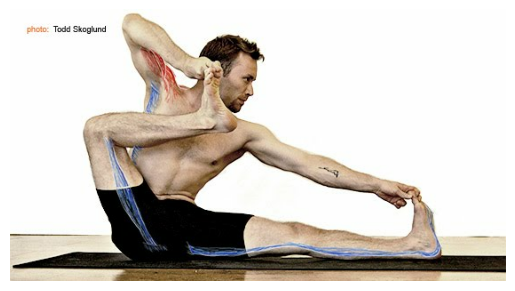

In [ ]:
plt.imshow(img.numpy())
plt.axis('off')

In [ ]:
# Rotate a point in 3D space by point (a,b,c)
def rotate_point(point, angles, arbitrary_point):
    """
    Rotate point (x,y,z) around pivot (a,b,c) by:
      - alpha around X-axis
      - beta  around Y-axis
      - gamma around Z-axis
    Angles in radians.
    Returns (x', y', z').
    """

    x, y, z = point
    a, b, c = arbitrary_point
    alpha, beta, gamma = angles

    # # 1) Translate point so pivot becomes origin:
    # x0 = x - a
    # y0 = y - b
    # z0 = z - c

    # # 2) Rotate around X-axis by alpha:
    ca, sa = math.cos(alpha), math.sin(alpha)
    # y1 =  ca*y0 - sa*z0
    # z1 =  sa*y0 + ca*z0
    # x1 =  x0

    # # 3) Rotate around Y-axis by beta:
    cb, sb = math.cos(beta), math.sin(beta)
    # x2 =  cb*x1 + sb*z1
    # z2 = -sb*x1 + cb*z1
    # y2 =  y1

    # # 4) Rotate around Z-axis by gamma:
    cg, sg = math.cos(gamma), math.sin(gamma)
    # x3 =  cg*x2 - sg*y2
    # y3 =  sg*x2 + cg*y2
    # z3 =  z2

    # # 5) Translate back by adding pivot:
    # x_prime = x3 + a
    # y_prime = y3 + b
    # z_prime = z3 + c

    x_prime = cg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) - sg*(ca*(y - b) - sa*(z - c)) + a
    y_prime = sg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) + cg*(ca*(y - b) - sa*(z - c)) + b
    z_prime = -sb*(x - a) + cb*(sa*(y - b) + ca*(z - c)) + c

    return x_prime, y_prime, z_prime

In [ ]:
def visualize_landmarks(image_path):
  mp_drawing = mp.solutions.drawing_utils
  mp_pose = mp.solutions.pose

  with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
      # Draw landmarks on the image
      annotated_image = image.copy()
      mp_drawing.draw_landmarks(
          annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

      # Display the annotated image using Matplotlib
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
      plt.title("Pose Landmarks")
      plt.axis('off')  # Hide axes
      plt.show()
    else:
      print("No pose landmarks detected in the image.")

In [ ]:
len(results.pose_landmarks.landmark)
# print(results.pose_landmarks.landmark)

(-0.5, 558.5, 305.5, -0.5)

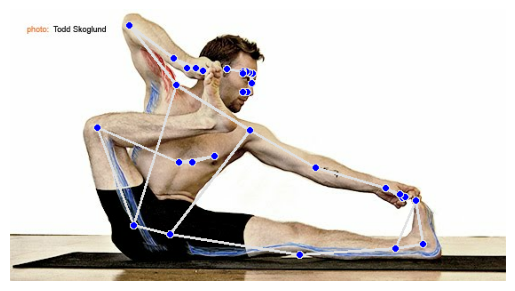

In [ ]:
annonated_image = img.numpy().copy()
mpDraw.draw_landmarks(annonated_image, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
plt.imshow(annonated_image)
plt.axis('off')

In [ ]:
classes = np.unique(os.listdir(validation_dir))
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 82


In [ ]:
classes

In [ ]:
label_lookup = tf.keras.layers.StringLookup(
    vocabulary = classes,
    mask_token = None,
    num_oov_indices = 0
)

In [ ]:
tf.data.experimental.enable_debug_mode()
def process_image(image_path):
  label = tf.strings.split(image_path, os.sep)[-2]
  encoded_label = label_lookup(label)

  img = tf.io.read_file(image_path)

  try:
    img = tf.image.decode_jpeg(img, channels=3)
  except:
    return np.zeros((0,3)), encoded_label

  img = tf.image.resize(img, [128, 128])

  def extract_features(img):
    features = []
    img = tf.cast(img, dtype=tf.uint8).numpy()

    results = pose.process(img)
    if results.pose_landmarks:
      for landmark in results.pose_landmarks.landmark:
        features.append([landmark.x, landmark.y, landmark.z])
      return np.array(features)
    else:
      return np.zeros((0,3))

  features = tf.py_function(extract_features, [img], [tf.float32])
  return features, encoded_label

def split_points(features, labels):
  features = tf.reshape(features, [-1, 33, 3])
  labels = tf.repeat(labels, tf.shape(features)[0])
  return tf.data.Dataset.from_tensor_slices((features, labels))

def extract_keypoints_dataset(path):
  dataset = tf.data.Dataset.list_files(f'{path}/*/*', shuffle=False)

  processed_dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
  processed_dataset = processed_dataset.filter(lambda x,y: tf.shape(x)[1]>0)  # Remove out None values
  processed_dataset = processed_dataset.flat_map(split_points)  # Flatten the dataset
  return processed_dataset

In [ ]:
train_dataset = extract_keypoints_dataset(train_dir).shuffle(1000).cache()
for data in train_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (33, 3) Label: tf.Tensor(5, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(6, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(5, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(4, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(2, shape=(), dtype=int64)


In [ ]:
validation_dataset = extract_keypoints_dataset(validation_dir).shuffle(500).cache()
for data in validation_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (33, 3) Label: tf.Tensor(12, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(13, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(10, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(5, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(3, shape=(), dtype=int64)


In [ ]:
test_dataset = extract_keypoints_dataset(test_dir).shuffle(500).cache()
for data in test_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (33, 3) Label: tf.Tensor(6, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(2, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(18, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(8, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(13, shape=(), dtype=int64)


In [ ]:
train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
# # Image data generators
# train_datagen = ImageDataGenerator(rescale=1.0/255.0,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(150, 150),
#                                                     batch_size=32,
#                                                     class_mode='categorical')

# validation_generator = validation_datagen.flow_from_directory(validation_dir,
#                                                               target_size=(150, 150),
#                                                               batch_size=32,
#                                                               class_mode='categorical')

# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   target_size=(150, 150),
#                                                   batch_size=32,
#                                                   class_mode='categorical',
#                                                   shuffle=False)

In [ ]:
model = Sequential([
    Input(shape=(33, 3)),
    Flatten(),
    BatchNormalization(),
    Dense(1024, activation='leaky_relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(768, activation='leaky_relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(512, activation='leaky_relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='leaky_relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_dataset,
    epochs=300,
    steps_per_epoch=85,
    validation_data=validation_dataset,
    validation_steps=26
)

In [ ]:
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f"Test accuracy: {test_acc}")
model.save('yoga_trainer_model.keras')

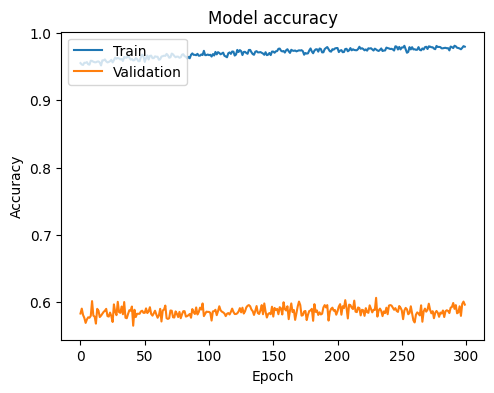

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

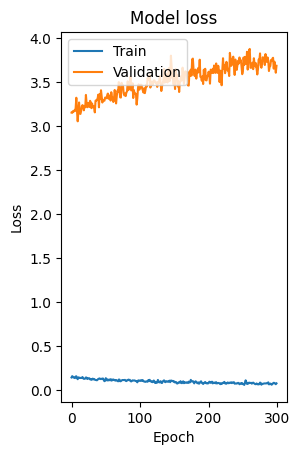

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
img=tf.io.read_file('/content/large_dataset/test/Akarna_Dhanurasana/Akarna_Dhanurasana_image_76.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

In [ ]:
features=[[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
ypred=model.predict(np.array([features])).argmax(axis=1)
print('Pose Predicted:', label_lookup.get_vocabulary()[ypred[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Pose Predicted: Upward_Plank_Pose_or_Purvottanasana_


In [ ]:
label_lookup.save_assets('label_lookup_')